## DCGAN model

In [1]:
import torch
import torch.nn as nn

# The Generator model
class Generator(nn.Module):
    def __init__(self, channels, noise_dim=100, embed_dim=1024, embed_out_dim=128):
        super(Generator, self).__init__()
        self.channels = channels
        self.noise_dim = noise_dim
        self.embed_dim = embed_dim
        self.embed_out_dim = embed_out_dim

        # Text embedding layers
        self.text_embedding = nn.Sequential(
            nn.Linear(self.embed_dim, self.embed_out_dim),
            nn.BatchNorm1d(self.embed_out_dim),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Generator architecture
        model = []
        model += self._create_layer(self.noise_dim + self.embed_out_dim, 512, 4, stride=1, padding=0)
        model += self._create_layer(512, 256, 4, stride=2, padding=1)
        model += self._create_layer(256, 128, 4, stride=2, padding=1)
        model += self._create_layer(128, 64, 4, stride=2, padding=1)
        model += self._create_layer(64, self.channels, 4, stride=2, padding=1, output=True)

        self.model = nn.Sequential(*model)

    def _create_layer(self, size_in, size_out, kernel_size=4, stride=2, padding=1, output=False):
        layers = [nn.ConvTranspose2d(size_in, size_out, kernel_size, stride=stride, padding=padding, bias=False)]
        if output:
            layers.append(nn.Tanh())  # Tanh activation for the output layer
        else:
            layers += [nn.BatchNorm2d(size_out), nn.ReLU(True)]  # Batch normalization and ReLU for other layers
        return layers

    def forward(self, noise, text):
        # Apply text embedding to the input text
        text = self.text_embedding(text)
        text = text.view(text.shape[0], text.shape[1], 1, 1)  # Reshape to match the generator input size
        z = torch.cat([text, noise], 1)  # Concatenate text embedding with noise
        return self.model(z)


# The Embedding model
class Embedding(nn.Module):
    def __init__(self, size_in, size_out):
        super(Embedding, self).__init__()
        self.text_embedding = nn.Sequential(
            nn.Linear(size_in, size_out),
            nn.BatchNorm1d(size_out),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x, text):
        embed_out = self.text_embedding(text)
        embed_out_resize = embed_out.repeat(4, 4, 1, 1).permute(2, 3, 0, 1)  # Resize to match the discriminator input size
        out = torch.cat([x, embed_out_resize], 1)  # Concatenate text embedding with the input feature map
        return out


# The Discriminator model
class Discriminator(nn.Module):
    def __init__(self, channels, embed_dim=1024, embed_out_dim=128):
        super(Discriminator, self).__init__()
        self.channels = channels
        self.embed_dim = embed_dim
        self.embed_out_dim = embed_out_dim

        # Discriminator architecture
        self.model = nn.Sequential(
            *self._create_layer(self.channels, 64, 4, 2, 1, normalize=False),
            *self._create_layer(64, 128, 4, 2, 1),
            *self._create_layer(128, 256, 4, 2, 1),
            *self._create_layer(256, 512, 4, 2, 1)
        )
        self.text_embedding = Embedding(self.embed_dim, self.embed_out_dim)  # Text embedding module
        self.output = nn.Sequential(
            nn.Conv2d(512 + self.embed_out_dim, 1, 4, 1, 0, bias=False), nn.Sigmoid()
        )

    def _create_layer(self, size_in, size_out, kernel_size=4, stride=2, padding=1, normalize=True):
        layers = [nn.Conv2d(size_in, size_out, kernel_size=kernel_size, stride=stride, padding=padding)]
        if normalize:
            layers.append(nn.BatchNorm2d(size_out))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        return layers

    def forward(self, x, text):
        x_out = self.model(x)  # Extract features from the input using the discriminator architecture
        out = self.text_embedding(x_out, text)  # Apply text embedding and concatenate with the input features
        out = self.output(out)  # Final discriminator output
        return out.squeeze(), x_out

## Utils

In [2]:
import torch

def process_caption(caption, max_caption_length=200, alphabet="abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{} "):
    """
    Converts a caption string to a tensor of one-hot encoded vectors based on the given alphabet.

    Args:
        caption (str): The input caption to be converted to one-hot encoded vectors.
        max_caption_length (int): The maximum length of the output label sequence. If the caption is longer, it will be truncated.
        alphabet (str, optional): The alphabet used to map characters to numeric labels and define the length of the one-hot vectors. Default is a combination of lowercase letters, numbers, and common punctuation marks.

    Returns:
        torch.Tensor: A tensor containing the one-hot encoded vectors for the caption.
    """
    # Convert the caption to lowercase for case-insensitivity
    caption = caption.lower()

    # Create a mapping from characters in the alphabet to numeric labels
    alpha_to_num = {k: v + 1 for k, v in zip(alphabet, range(len(alphabet)))}

    # Initialize the output tensor with zeros and set the data type to long
    labels = torch.zeros(max_caption_length).long()

    # Determine the maximum number of characters to process from the caption
    max_i = min(max_caption_length, len(caption))

    # Convert each character in the caption to its corresponding numeric label
    for i in range(max_i):
        # If the character is not in the alphabet, use the numeric label for space (' ')
        labels[i] = alpha_to_num.get(caption[i], alpha_to_num[' '])

    labels = labels.unsqueeze(1)

    # Convert the numeric labels to one-hot encoded vectors
    # Initialize a tensor of zeros with the shape (sequence length, alphabet length + 1) and scatter ones based on the labels
    one_hot = torch.zeros(labels.size(0), len(alphabet) + 1).scatter_(1, labels, 1.)

    # Remove the column corresponding to the numeric label 0 (used for padding)
    one_hot = one_hot[:, 1:]

    # Permute the tensor to have the sequence length as the first dimension
    one_hot = one_hot.permute(1, 0)

    return one_hot

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

## Data Util

In [ ]:
import os
import io
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
import pdb
from PIL import Image
import torch
from torch.autograd import Variable
import pdb
import torch.nn.functional as F

class Text2ImageDataset(Dataset):

    def __init__(self, datasetFile, transform=None, split=0):
        self.datasetFile = datasetFile
        self.transform = transform
        self.dataset = None
        self.dataset_keys = None
        self.split = 'train' if split == 0 else 'valid' if split == 1 else 'test'
        self.h5py2int = lambda x: int(np.array(x))

    def __len__(self):
        f = h5py.File(self.datasetFile, 'r')
        self.dataset_keys = [str(k) for k in f[self.split].keys()]
        length = len(f[self.split])
        f.close()

        return length

    def __getitem__(self, idx):
        if self.dataset is None:
            self.dataset = h5py.File(self.datasetFile, mode='r')
            self.dataset_keys = [str(k) for k in self.dataset[self.split].keys()]

        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]

        # pdb.set_trace()

        right_image = bytes(np.array(example['img']))
        right_embed = np.array(example['embeddings'], dtype=float)
        wrong_image = bytes(np.array(self.find_wrong_image(example['class'])))
        inter_embed = np.array(self.find_inter_embed())

        right_image = Image.open(io.BytesIO(right_image)).resize((64, 64))
        wrong_image = Image.open(io.BytesIO(wrong_image)).resize((64, 64))

        right_image = self.validate_image(right_image)
        wrong_image = self.validate_image(wrong_image)

        try:
            txt = np.array(example['txt']).astype(str)
        except:

            txt = np.array([example['txt'][()].decode('utf-8', errors='replace')])
            txt = np.char.replace(txt, '�', ' ').astype(str)

        sample = {
                'right_images': torch.FloatTensor(right_image),
                'right_embed': torch.FloatTensor(right_embed),
                'wrong_images': torch.FloatTensor(wrong_image),
                'inter_embed': torch.FloatTensor(inter_embed),
                'txt': str(txt)
                 }

        sample['right_images'] = sample['right_images'].sub_(127.5).div_(127.5)
        sample['wrong_images'] =sample['wrong_images'].sub_(127.5).div_(127.5)

        return sample

    def find_wrong_image(self, category):
        idx = np.random.randint(len(self.dataset_keys))
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]
        _category = example['class']

        if _category != category:
            return example['img']

        return self.find_wrong_image(category)

    def find_inter_embed(self):
        idx = np.random.randint(len(self.dataset_keys))
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]
        return example['embeddings']


    def validate_image(self, img):
        img = np.array(img, dtype=float)
        if len(img.shape) < 3:
            rgb = np.empty((64, 64, 3), dtype=np.float32)
            rgb[:, :, 0] = img
            rgb[:, :, 1] = img
            rgb[:, :, 2] = img
            img = rgb

        return img.transpose(2, 0, 1)

## Libraries

In [5]:
import torch
import torch.nn as nn
import torchvision.utils as vutils
from torch.autograd import Variable
from torch.utils.data import DataLoader

import os
import time
import imageio
from datetime import datetime
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Setup

In [6]:
# Setting device to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using Device", device)

Using Device cpu


In [7]:
# saving current date and time
date = datetime.now().strftime('%Y%m%d')
start_time = time.time()

In [8]:
# directory to store output images
output_save_path = './generated_images/'
os.makedirs(output_save_path, exist_ok=True)

In [9]:
# directory to store trained models
model_save_path = './saved_models/'
os.makedirs(model_save_path, exist_ok=True)

In [10]:
# setting up parameters
noise_dim = 100
embed_dim = 1024
embed_out_dim = 128
batch_size = 256 #128
real_label = 1.
fake_label = 0.
learning_rate = 0.0002
l1_coef = 50
l2_coef = 100

num_epochs = 250
log_interval = 18 #43

In [10]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("chinmay4400/birds-hd5")

print("Path to dataset files:", path)

100%|██████████| 5.05G/5.05G [01:02<00:00, 86.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/chinmay4400/birds-hd5/versions/1


In [13]:
# loading dataset
train_dataset = Text2ImageDataset('/root/.cache/kagglehub/datasets/chinmay4400/birds-hd5/versions/1/birds.hdf5',split=0) # split { 0: train, 1: validation, 2: test }
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,num_workers=8)
print("No of batches: ",len(train_loader))

No of batches:  108


In [11]:
# loss functions
criterion = nn.BCELoss()
l2_loss = nn.MSELoss()
l1_loss = nn.L1Loss()

In [12]:
# lists to store losses
D_losses = []
G_losses = []

## Training

In [12]:
# initializing generator
generator = Generator(channels=3, embed_dim=embed_dim, noise_dim=noise_dim, embed_out_dim=embed_out_dim).to(device)
generator.apply(weights_init)

Generator(
  (text_embedding): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): ConvTranspose2d(228, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=Fa

In [13]:
# initializing discriminator
discriminator = Discriminator(channels=3, embed_dim=embed_dim, embed_out_dim=embed_out_dim).to(device)
discriminator.apply(weights_init)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (text_embedding): Embedding(
    (text_embedding): Sequential(
      (0): Linear(in_features=1024, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, mo

In [14]:
import os
import torch

# Задайте пути к сохранённым моделям
generator_path = os.path.join(model_save_path, f'generator_epoch_50.pth')
discriminator_path = os.path.join(model_save_path, f'discriminator_epoch_50.pth')

# Инициализация моделей
generator = Generator(channels=3, embed_dim=embed_dim, noise_dim=noise_dim, embed_out_dim=embed_out_dim).to(device)
discriminator = Discriminator(channels=3, embed_dim=embed_dim, embed_out_dim=embed_out_dim).to(device)

# Проверка на наличие предобученных весов и загрузка
if os.path.exists(generator_path):
    generator.load_state_dict(torch.load(generator_path, map_location=device))
    print(f'Загружены веса генератора из {generator_path}')
else:
    generator.apply(weights_init)  # Инициализация, если веса не найдены
    print(f'Файл с весами генератора не найден: {generator_path}')

if os.path.exists(discriminator_path):
    discriminator.load_state_dict(torch.load(discriminator_path, map_location=device))
    print(f'Загружены веса дискриминатора из {discriminator_path}')
else:
    discriminator.apply(weights_init)  # Инициализация, если веса не найдены
    print(f'Файл с весами дискриминатора не найден: {discriminator_path}')

# Перемещение моделей на устройство
generator.to(device)
discriminator.to(device)

# Теперь продолжайте с циклом обучения

Загружены веса генератора из ./saved_models/generator_epoch_50.pth
Загружены веса дискриминатора из ./saved_models/discriminator_epoch_50.pth


Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (text_embedding): Embedding(
    (text_embedding): Sequential(
      (0): Linear(in_features=1024, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, mo

In [15]:
# setting up Adam optimizer for Generator and Discriminator
optimizer_G = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

In [ ]:
import time
import torch
import torchvision.utils as vutils
from tqdm import tqdm
import os

# training loop

# iterating over number of epochs
for epoch in range(num_epochs):
    epoch_start_time = time.time()

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
        for batch_idx, batch in enumerate(train_loader):
            batch_time = time.time()

            images = batch['right_images'].to(device)
            wrong_images = batch['wrong_images'].to(device)
            embeddings = batch['right_embed'].to(device)
            batch_size = images.size(0)

            # ================================================================== #
            #                      Train the discriminator                       #
            # ================================================================== #
            optimizer_D.zero_grad()
            noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)
            fake_images = generator(noise, embeddings)

            real_out, real_act = discriminator(images, embeddings)
            d_loss_real = criterion(real_out, torch.full_like(real_out, real_label, device=device))

            wrong_out, wrong_act = discriminator(wrong_images, embeddings)
            d_loss_wrong = criterion(wrong_out, torch.full_like(wrong_out, fake_label, device=device))

            fake_out, fake_act = discriminator(fake_images.detach(), embeddings)
            d_loss_fake = criterion(fake_out, torch.full_like(fake_out, fake_label, device=device))

            d_loss = d_loss_real + d_loss_wrong + d_loss_fake
            d_loss.backward()
            optimizer_D.step()

            # ================================================================== #
            #                        Train the generator                         #
            # ================================================================== #
            optimizer_G.zero_grad()
            noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)
            fake_images = generator(noise, embeddings)

            out_fake, act_fake = discriminator(fake_images, embeddings)
            out_real, act_real = discriminator(images, embeddings)

            g_bce = criterion(out_fake, torch.full_like(out_fake, real_label, device=device))
            g_l1 = l1_coef * l1_loss(fake_images, images)
            g_l2 = l2_coef * l2_loss(torch.mean(act_fake, 0), torch.mean(act_real, 0).detach())

            g_loss = g_bce + g_l1 + g_l2
            g_loss.backward()
            optimizer_G.step()

            D_losses.append(d_loss.item())
            G_losses.append(g_loss.item())

            pbar.set_postfix(loss_D=d_loss.item(), loss_G=g_loss.item())
            pbar.update(1)

            if batch_idx == len(train_loader) - 1 and ((epoch + 1) % 10 == 0 or epoch == 0):
                viz_sample = torch.cat((images[:32], fake_images[:32]), 0)
                vutils.save_image(viz_sample,
                                   os.path.join(output_save_path, f'output_{date}_epoch_{epoch + 1}.png'),
                                   nrow=8, normalize=True)

                # Сохраняем модели каждые 10 эпох
                torch.save(generator.state_dict(), os.path.join(model_save_path, f'generator_epoch_{epoch + 1}.pth'))
                torch.save(discriminator.state_dict(), os.path.join(model_save_path, f'discriminator_epoch_{epoch + 1}.pth'))

    epoch_duration = time.time() - epoch_start_time
    print(f'Epoch {epoch + 1} completed in {epoch_duration:.2f} seconds.')

# saving the final models
torch.save(generator.state_dict(), os.path.join(model_save_path, f'generator_final_{date}.pth'))
torch.save(discriminator.state_dict(), os.path.join(model_save_path, f'discriminator_final_{date}.pth'))

print('Total train time: {:.2f}'.format(time.time() - start_time))

Epoch 1/250: 100%|██████████| 108/108 [03:56<00:00,  2.19s/batch, loss_D=1.57, loss_G=27.5]


Epoch 1 completed in 236.27 seconds.


Epoch 2/250: 100%|██████████| 108/108 [03:59<00:00,  2.22s/batch, loss_D=1.53, loss_G=26.3]


Epoch 2 completed in 239.33 seconds.


Epoch 3/250: 100%|██████████| 108/108 [03:51<00:00,  2.14s/batch, loss_D=1.16, loss_G=27.5]


Epoch 3 completed in 231.63 seconds.


Epoch 4/250: 100%|██████████| 108/108 [03:49<00:00,  2.13s/batch, loss_D=2.01, loss_G=24.8]


Epoch 4 completed in 229.65 seconds.


Epoch 5/250: 100%|██████████| 108/108 [03:48<00:00,  2.12s/batch, loss_D=1.6, loss_G=26.1]


Epoch 5 completed in 228.50 seconds.


Epoch 6/250: 100%|██████████| 108/108 [03:49<00:00,  2.12s/batch, loss_D=2.02, loss_G=24]


Epoch 6 completed in 229.06 seconds.


Epoch 7/250: 100%|██████████| 108/108 [03:47<00:00,  2.11s/batch, loss_D=1.81, loss_G=26.6]


Epoch 7 completed in 227.79 seconds.


Epoch 8/250: 100%|██████████| 108/108 [03:47<00:00,  2.10s/batch, loss_D=1.54, loss_G=25.9]


Epoch 8 completed in 227.18 seconds.


Epoch 9/250: 100%|██████████| 108/108 [03:50<00:00,  2.13s/batch, loss_D=1.8, loss_G=25.6]


Epoch 9 completed in 230.39 seconds.


Epoch 10/250: 100%|██████████| 108/108 [03:48<00:00,  2.12s/batch, loss_D=1.59, loss_G=27.6]


Epoch 10 completed in 228.49 seconds.


Epoch 11/250: 100%|██████████| 108/108 [03:48<00:00,  2.12s/batch, loss_D=1.44, loss_G=27.4]


Epoch 11 completed in 228.49 seconds.


Epoch 12/250: 100%|██████████| 108/108 [03:49<00:00,  2.13s/batch, loss_D=1.91, loss_G=27.5]


Epoch 12 completed in 229.57 seconds.


Epoch 13/250: 100%|██████████| 108/108 [03:47<00:00,  2.11s/batch, loss_D=1.35, loss_G=25.8]


Epoch 13 completed in 227.61 seconds.


Epoch 14/250: 100%|██████████| 108/108 [03:47<00:00,  2.11s/batch, loss_D=2.15, loss_G=24.3]


Epoch 14 completed in 227.49 seconds.


Epoch 15/250: 100%|██████████| 108/108 [03:47<00:00,  2.10s/batch, loss_D=1.6, loss_G=25.5]


Epoch 15 completed in 227.16 seconds.


Epoch 16/250: 100%|██████████| 108/108 [03:48<00:00,  2.11s/batch, loss_D=3.17, loss_G=25]


Epoch 16 completed in 228.39 seconds.


Epoch 17/250: 100%|██████████| 108/108 [03:49<00:00,  2.12s/batch, loss_D=2.16, loss_G=26.3]


Epoch 17 completed in 229.24 seconds.


Epoch 18/250: 100%|██████████| 108/108 [03:47<00:00,  2.11s/batch, loss_D=1.82, loss_G=25.4]


Epoch 18 completed in 227.84 seconds.


Epoch 19/250: 100%|██████████| 108/108 [04:18<00:00,  2.39s/batch, loss_D=1.81, loss_G=23.5]


Epoch 19 completed in 258.59 seconds.


Epoch 20/250: 100%|██████████| 108/108 [03:47<00:00,  2.10s/batch, loss_D=1.53, loss_G=26.1]


Epoch 20 completed in 227.29 seconds.


Epoch 21/250: 100%|██████████| 108/108 [03:48<00:00,  2.11s/batch, loss_D=2.69, loss_G=24.4]


Epoch 21 completed in 228.15 seconds.


Epoch 22/250: 100%|██████████| 108/108 [03:49<00:00,  2.13s/batch, loss_D=2.59, loss_G=24.9]


Epoch 22 completed in 229.57 seconds.


Epoch 23/250: 100%|██████████| 108/108 [03:46<00:00,  2.10s/batch, loss_D=1.28, loss_G=25.9]


Epoch 23 completed in 226.66 seconds.


Epoch 24/250: 100%|██████████| 108/108 [03:49<00:00,  2.13s/batch, loss_D=1.72, loss_G=25.9]


Epoch 24 completed in 229.53 seconds.


Epoch 25/250: 100%|██████████| 108/108 [03:47<00:00,  2.11s/batch, loss_D=2.04, loss_G=25.8]


Epoch 25 completed in 227.92 seconds.


Epoch 26/250: 100%|██████████| 108/108 [03:44<00:00,  2.08s/batch, loss_D=1.74, loss_G=25.1]


Epoch 26 completed in 224.49 seconds.


Epoch 27/250: 100%|██████████| 108/108 [03:46<00:00,  2.09s/batch, loss_D=1.38, loss_G=24]


Epoch 27 completed in 226.05 seconds.


Epoch 28/250: 100%|██████████| 108/108 [03:46<00:00,  2.09s/batch, loss_D=1.5, loss_G=25.4]


Epoch 28 completed in 226.18 seconds.


Epoch 29/250: 100%|██████████| 108/108 [03:49<00:00,  2.12s/batch, loss_D=2.17, loss_G=22.7]


Epoch 29 completed in 229.22 seconds.


Epoch 30/250: 100%|██████████| 108/108 [03:47<00:00,  2.11s/batch, loss_D=1.87, loss_G=27.7]


Epoch 30 completed in 227.75 seconds.


Epoch 31/250: 100%|██████████| 108/108 [03:47<00:00,  2.10s/batch, loss_D=2.81, loss_G=25.3]


Epoch 31 completed in 227.12 seconds.


Epoch 32/250: 100%|██████████| 108/108 [03:48<00:00,  2.11s/batch, loss_D=1.27, loss_G=25.6]


Epoch 32 completed in 228.11 seconds.


Epoch 33/250: 100%|██████████| 108/108 [03:46<00:00,  2.09s/batch, loss_D=1.81, loss_G=24.9]


Epoch 33 completed in 226.23 seconds.


Epoch 34/250: 100%|██████████| 108/108 [03:46<00:00,  2.10s/batch, loss_D=1.91, loss_G=26.7]


Epoch 34 completed in 226.89 seconds.


Epoch 35/250: 100%|██████████| 108/108 [03:49<00:00,  2.12s/batch, loss_D=1.78, loss_G=25.3]


Epoch 35 completed in 229.51 seconds.


Epoch 36/250: 100%|██████████| 108/108 [03:47<00:00,  2.10s/batch, loss_D=1.83, loss_G=24.7]


Epoch 36 completed in 227.36 seconds.


Epoch 37/250: 100%|██████████| 108/108 [03:46<00:00,  2.10s/batch, loss_D=1.64, loss_G=25.6]


Epoch 37 completed in 226.57 seconds.


Epoch 38/250: 100%|██████████| 108/108 [03:46<00:00,  2.10s/batch, loss_D=1.41, loss_G=25.6]


Epoch 38 completed in 226.29 seconds.


Epoch 39/250: 100%|██████████| 108/108 [03:46<00:00,  2.10s/batch, loss_D=1.4, loss_G=26.1]


Epoch 39 completed in 226.89 seconds.


Epoch 40/250: 100%|██████████| 108/108 [03:49<00:00,  2.13s/batch, loss_D=1.82, loss_G=23.9]


Epoch 40 completed in 229.59 seconds.


Epoch 41/250: 100%|██████████| 108/108 [03:49<00:00,  2.12s/batch, loss_D=1.48, loss_G=25.3]


Epoch 41 completed in 229.19 seconds.


Epoch 42/250: 100%|██████████| 108/108 [03:46<00:00,  2.10s/batch, loss_D=2.09, loss_G=23.1]


Epoch 42 completed in 226.90 seconds.


Epoch 43/250: 100%|██████████| 108/108 [03:48<00:00,  2.11s/batch, loss_D=2.67, loss_G=22.3]


Epoch 43 completed in 228.38 seconds.


Epoch 44/250: 100%|██████████| 108/108 [03:47<00:00,  2.10s/batch, loss_D=1.79, loss_G=25.2]


Epoch 44 completed in 227.32 seconds.


Epoch 45/250: 100%|██████████| 108/108 [03:45<00:00,  2.09s/batch, loss_D=1.96, loss_G=24.1]


Epoch 45 completed in 225.90 seconds.


Epoch 46/250: 100%|██████████| 108/108 [03:46<00:00,  2.09s/batch, loss_D=1.6, loss_G=24.3]


Epoch 46 completed in 226.21 seconds.


Epoch 47/250: 100%|██████████| 108/108 [03:47<00:00,  2.10s/batch, loss_D=1.42, loss_G=24.6]


Epoch 47 completed in 227.27 seconds.


Epoch 48/250: 100%|██████████| 108/108 [03:46<00:00,  2.10s/batch, loss_D=1.29, loss_G=23.1]


Epoch 48 completed in 226.68 seconds.


Epoch 49/250: 100%|██████████| 108/108 [03:44<00:00,  2.08s/batch, loss_D=1.69, loss_G=24]


Epoch 49 completed in 224.87 seconds.


Epoch 50/250: 100%|██████████| 108/108 [03:47<00:00,  2.11s/batch, loss_D=2.34, loss_G=21.7]


Epoch 50 completed in 227.47 seconds.


Epoch 51/250: 100%|██████████| 108/108 [03:49<00:00,  2.12s/batch, loss_D=2.09, loss_G=23.8]


Epoch 51 completed in 229.25 seconds.


Epoch 52/250: 100%|██████████| 108/108 [03:45<00:00,  2.09s/batch, loss_D=1.52, loss_G=23.4]


Epoch 52 completed in 225.81 seconds.


Epoch 53/250: 100%|██████████| 108/108 [03:47<00:00,  2.11s/batch, loss_D=1.91, loss_G=21.8]


Epoch 53 completed in 227.50 seconds.


Epoch 54/250: 100%|██████████| 108/108 [03:46<00:00,  2.10s/batch, loss_D=1.7, loss_G=21.7]


Epoch 54 completed in 226.63 seconds.


Epoch 55/250: 100%|██████████| 108/108 [03:45<00:00,  2.08s/batch, loss_D=2.65, loss_G=22.8]


Epoch 55 completed in 225.21 seconds.


Epoch 56/250: 100%|██████████| 108/108 [03:47<00:00,  2.10s/batch, loss_D=1.65, loss_G=23.5]


Epoch 56 completed in 227.25 seconds.


Epoch 57/250:  22%|██▏       | 24/108 [00:57<01:25,  1.02s/batch, loss_D=1.93, loss_G=21.8]

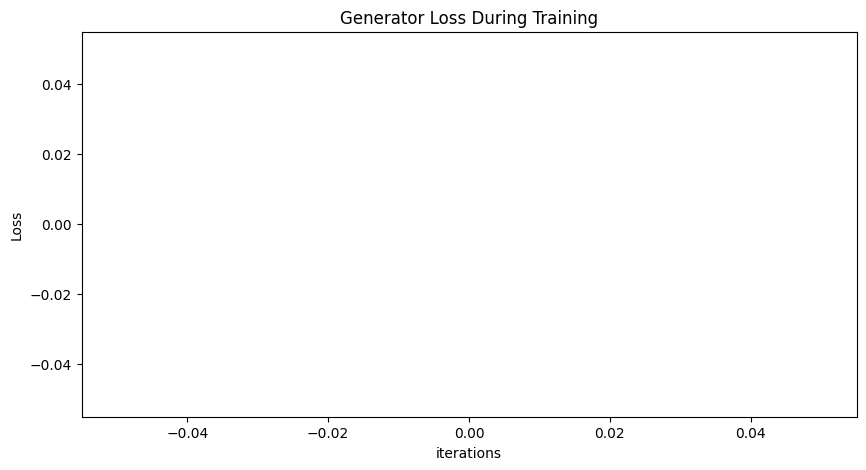

<Figure size 640x480 with 0 Axes>

In [16]:
# generator loss plot
plt.figure(figsize=(10,5))
plt.title("Generator Loss During Training")
plt.plot(G_losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

plt.savefig(os.path.join(output_save_path, 'output_generatorLoss_{}.png'.format(date)))

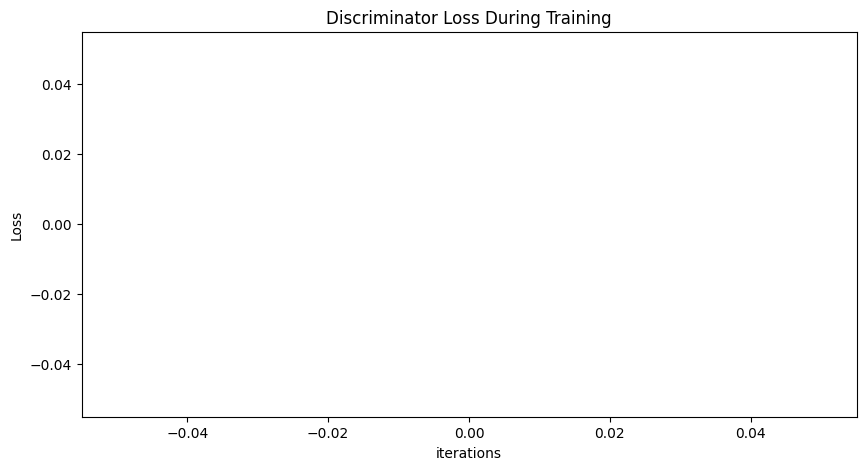

<Figure size 640x480 with 0 Axes>

In [18]:
# discriminator loss plot
plt.figure(figsize=(10,5))
plt.title("Discriminator Loss During Training")
plt.plot(D_losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

plt.savefig(os.path.join(output_save_path, 'output_discriminatorLoss_{}.png'.format(date)))

## Visualize output

In [17]:
# Get all file names from the "generated_images" directory
file_names = os.listdir(output_save_path)
file_names = [name for name in file_names if name.startswith('output_{}_'.format(date))]

# Sort the file names numerically
file_names = sorted(file_names, key=lambda name: int(name.split('_')[3].split('.')[0]))

# Create a list to store the read images
images = []

for file_name in file_names:
    images.append(imageio.imread(os.path.join(output_save_path,file_name)))

imageio.mimsave(os.path.join(output_save_path, 'output_gif_{}.gif'.format(date)), images, fps=1)

ValueError: need at least one array to stack

In [18]:
from IPython.display import Image

# Load the GIF
with open(os.path.join(output_save_path, 'output_gif_{}.gif'.format(date)),'rb') as file:
    display(Image(file.read()))

FileNotFoundError: [Errno 2] No such file or directory: './generated_images/output_gif_20250315.gif'

In [39]:
from transformers import BertTokenizer, BertModel
import torch

# Загрузка предобученного BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Пример текста
caption = "a bird"

# Токенизация текста
inputs = tokenizer(caption, return_tensors="pt")

# Генерация эмбеддингов текста с помощью BERT
outputs = model(**inputs)

# Используем среднее значение по всем токенам как эмбеддинг текста
text_embedding_tensor = outputs.last_hidden_state.mean(dim=1)

# Преобразование для добавления размера батча
# text_embedding_tensor = text_embedding_tensor.view(1, -1)
# print(text_embedding_tensor.shape)

# Проекция с 768 до 1024
projection_layer = nn.Linear(768, 1024)

# Применяем проекцию к текстовому эмбеддингу
text_embedding_tensor_1024 = projection_layer(text_embedding_tensor)

print(text_embedding_tensor_1024.shape)  # Должен быть [1, 1024]
print(text_embedding_tensor_1024)


torch.Size([1, 1024])
tensor([[-0.0509, -0.1825, -0.0498,  ..., -0.1835, -0.1892,  0.0707]],
       grad_fn=<AddmmBackward0>)


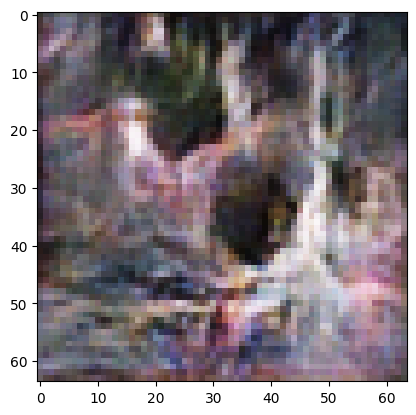

In [40]:
import torch

# Генерация случайного шума для модели
noise = torch.randn(1, 100, 1, 1)
generator.eval()

# Генерация изображения с использованием текстового эмбеддинга
with torch.no_grad():
    generated_image = generator(noise, text_embedding_tensor_1024)

# Преобразование изображения для отображения
generated_image = generated_image.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Преобразование диапазона значений от [-1, 1] до [0, 1]
generated_image = (generated_image + 1) / 2

# Отображение изображения
import matplotlib.pyplot as plt
plt.imshow(generated_image)
plt.show()